### Model family graph visualization
Here is an example to create a model family using Alexnet layers and display the results in a graph

In [1]:
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
import pyrsa
from pyrsa.model import ModelFamily

### Load model RDMs
Here the models are different layers of Alexnet.
For each layer, different models of how the fMRI voxels sample the neurons are being considered.

The simulated data were generated in Matlab (Kriegeskorte & Diedrichsen 2016). Thus, we load the Matlab files in .mat format.

For each model-RDM, we obtain the RDM itself, a model name, and a measurement model name. The model name specifies the layer used to generate the RDM. The measurement model name specifies the applied distortions.

In [2]:
matlab_data = io.matlab.loadmat('rdms_inferring/modelRDMs_A2020.mat')
matlab_data = matlab_data['modelRDMs']
n_models = len(matlab_data[0])
model_names = [matlab_data[0][i][0][0] for i in range(n_models)]
measurement_model = [matlab_data[0][i][1][0] for i in range(n_models)]
rdms_array = np.array([matlab_data[0][i][3][0] for i in range(n_models)])
model_rdms = pyrsa.rdm.RDMs(rdms_array,
                            rdm_descriptors={'brain_computational_model':model_names,
                                             'measurement_model':measurement_model},
                            dissimilarity_measure='Euclidean'
                           )

### Load and choose data RDMs
Here we use simulated data to demonstrate RSA inference.
Since we know the true data-generating model in each case, we can tell when inference fails or succeeds.

For each data RDM, we obtain the name of the underlying Layer, a full width at half maximum (FWHM) value and a noise standard deviation. The FWHM value specifies the spatial range the simulated voxels average over. The noise standard deviation specifies how much noise was added to the voxel responses.

We then choose which data RDMs we use for the exercise. You can change the representation, the noise level and the amount of averaging by chaning the index values at the beginning.

We then convert the chosen data RDMs into an pyrsa RDMs object and display them as we did for the model RDMs.

In [3]:
matlab_data = io.matlab.loadmat('rdms_inferring/noisyModelRDMs_A2020.mat')
repr_names_matlab = matlab_data['reprNames']
fwhms_matlab = matlab_data['FWHMs']
noise_std_matlab = matlab_data['relNoiseStds']
rdms_matlab = matlab_data['noisyModelRDMs']
repr_names = [repr_names_matlab[i][0][0] for i in range(repr_names_matlab.shape[0])]
fwhms = fwhms_matlab.squeeze().astype('float')
noise_std = noise_std_matlab.squeeze().astype('float')
rdms_matrix = rdms_matlab.squeeze().astype('float')
# indices choosing brain-computational model, noise level, and the size of the kernel with which each voxel samples the neural activity
i_rep = 2 #np.random.randint(len(repr_names)) 
i_noise = 1 #np.random.randint(len(noise_std))
i_fwhm = 0 #np.random.randint(len(fwhms))

# print the chosen representation definition
repr_name = repr_names[i_rep]
print('The chosen ground truth model is:')
print(repr_name)
print('with noise level:')
print(noise_std[i_noise])
print('with averaging width (full width at half magnitude):')
print(fwhms[i_fwhm])

# put the rdms into an RDMs object and show it
rdms_data = pyrsa.rdm.RDMs(rdms_matrix[:, i_rep, i_fwhm, i_noise, :].transpose())

The chosen ground truth model is:
conv3
with noise level:
3.0
with averaging width (full width at half magnitude):
0.0


### Define fixed models
An "RDM model" is a pyRSA object that can predict a data RDM.
For example, a flexible RDM model may contain a set of predictor RDMs, which predict the data RDM as a weighted combination.
Here we use fixed RDM models, which contain just a single RDM with no parameters to be fitted.

Models are generated by first choosing the RDM, in this case the one with the right "brain_computational_model" and the "measurement_model" "complete", which corresponds to no distortions added. This object is then passed to the function `pyrsa.model.ModelFixed`, which generates a fixed RDM model. These RDM models are then collected in the list `models`. 

In [4]:
models = []
for i_model in np.unique(model_names):
    rdm_m = model_rdms.subset('brain_computational_model', i_model).subset('measurement_model','smooth1rpwavgFeat')
    m = pyrsa.model.ModelFixed(i_model, rdm_m)
    models.append(m)

C:\Users\kshitij\Anaconda3\envs\dnn2brain_fn\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\kshitij\Anaconda3\envs\dnn2brain_fn\lib\site-packages\numpy\core\_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


### Crossvalidation
As a first step, we split our data into training and test sets, which should not share either subjects or stimuli. To do so, we split each dimension into k groups and leave one of these groups out as a testset and use all others as training data. Models choose their parameters to maximize performance on the training set and are evaluated on the test set. Additionally a so-called *ceil set* is created, which contains the data from the training subjects for the test stimuli, which is necessary for calculating a noise ceiling.

The variables `k_pattern` and `k_rdm` specify how many folds should be formed over stimuli and subjects, respectively.

In [5]:
train_set, test_set, ceil_set = pyrsa.inference.sets_k_fold(rdms_data, k_pattern=3, k_rdm=4,pattern_descriptor='index')

### Create Model Family
Here we create model family from first four layers of Alexnet

In [6]:

model_family = ModelFamily(models[0:4])

### Evaluate model family and plot bars for each family member

d:\projects\fun\pyrsa\pyrsa\util\inference_util.py:162: RuntimeWarning: invalid value encountered in long_scalars
  np.sum(evaluations[:, i_model] == evaluations[:, j_model]))
d:\projects\fun\pyrsa\pyrsa\vis\model_plot.py:324: RuntimeWarning: invalid value encountered in less
  k_ok = ps < criterion
d:\projects\fun\pyrsa\pyrsa\vis\model_plot.py:330: RuntimeWarning: invalid value encountered in less
  significant = p_values < crit


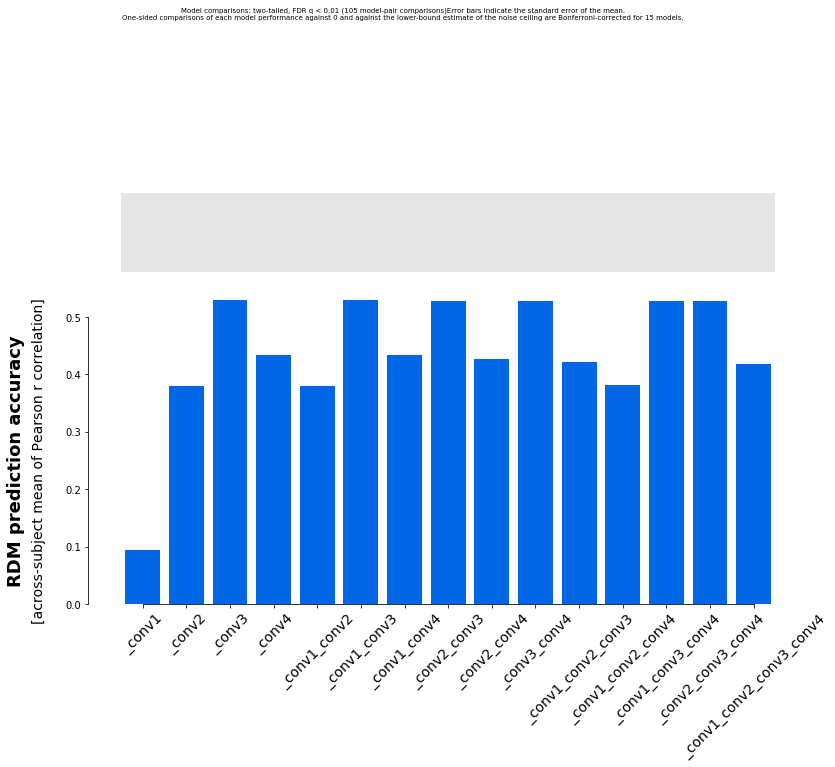

In [7]:
results = pyrsa.inference.crossval(model_family.get_all_family_members(), rdms_data, train_set, test_set,
                                        ceil_set=ceil_set, method='corr')
# plot results
pyrsa.vis.plot_model_comparison(results)

### visualizing family graph
We can visualize the above bar plot in a more convenient way using Graph where each node represents a family member.
1. Numbers inside the node represent which layers were selected in that family member. 
2. We can choose color/area of the node proportional to its performance. 
3. Edges are always directed towards increase in performance. 
4. The width of the edges indicates the improvement in performance when going from one node to other

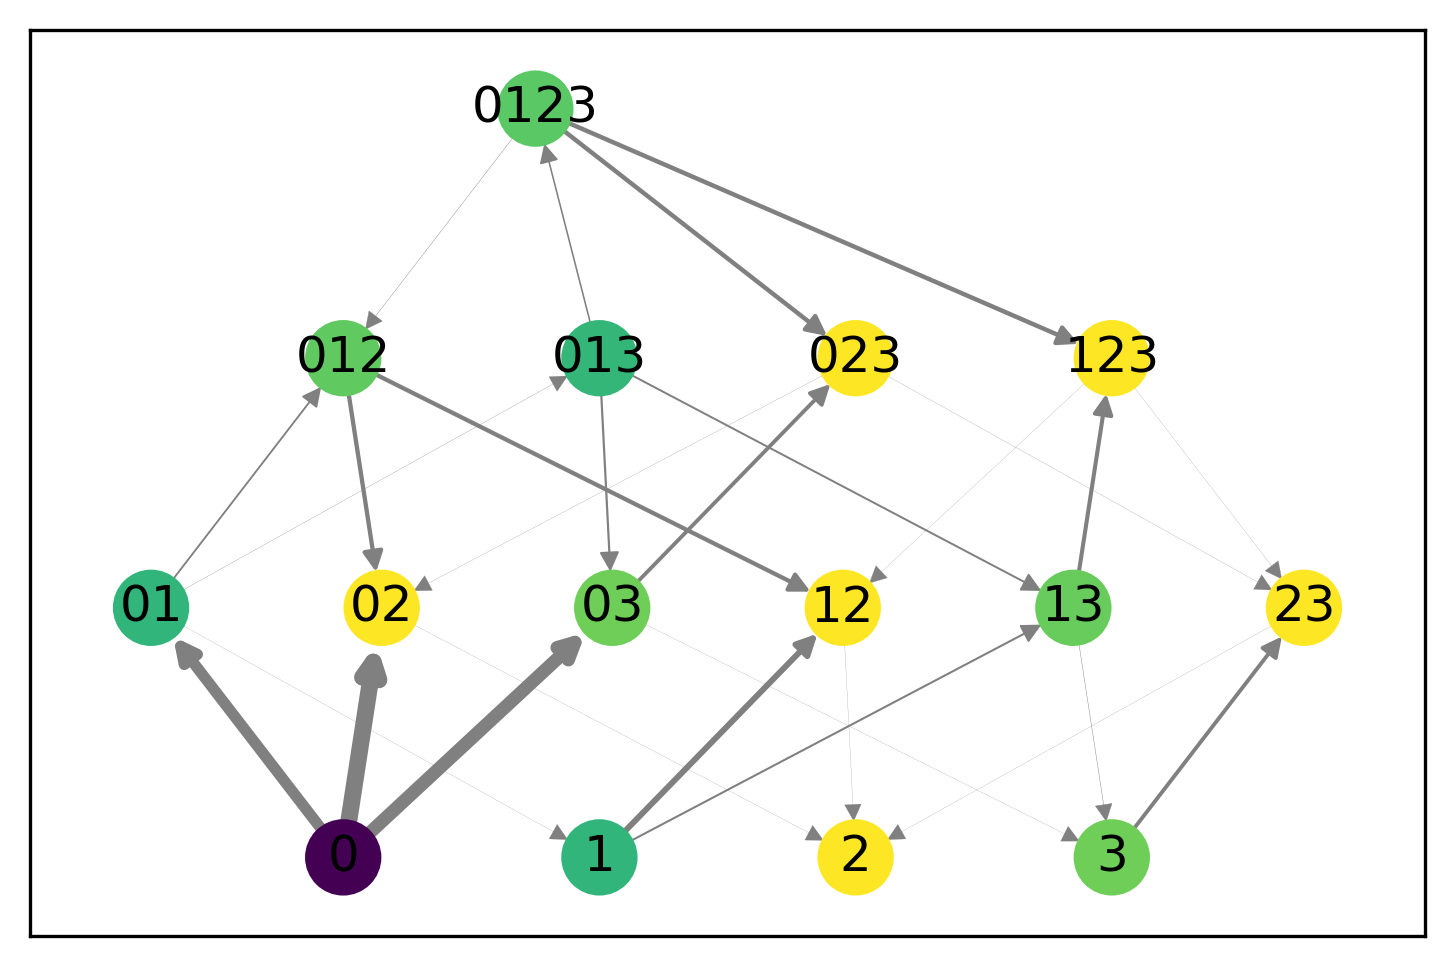

In [8]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
pyrsa.vis.show_family_graph(model_family,results,node_property="color")

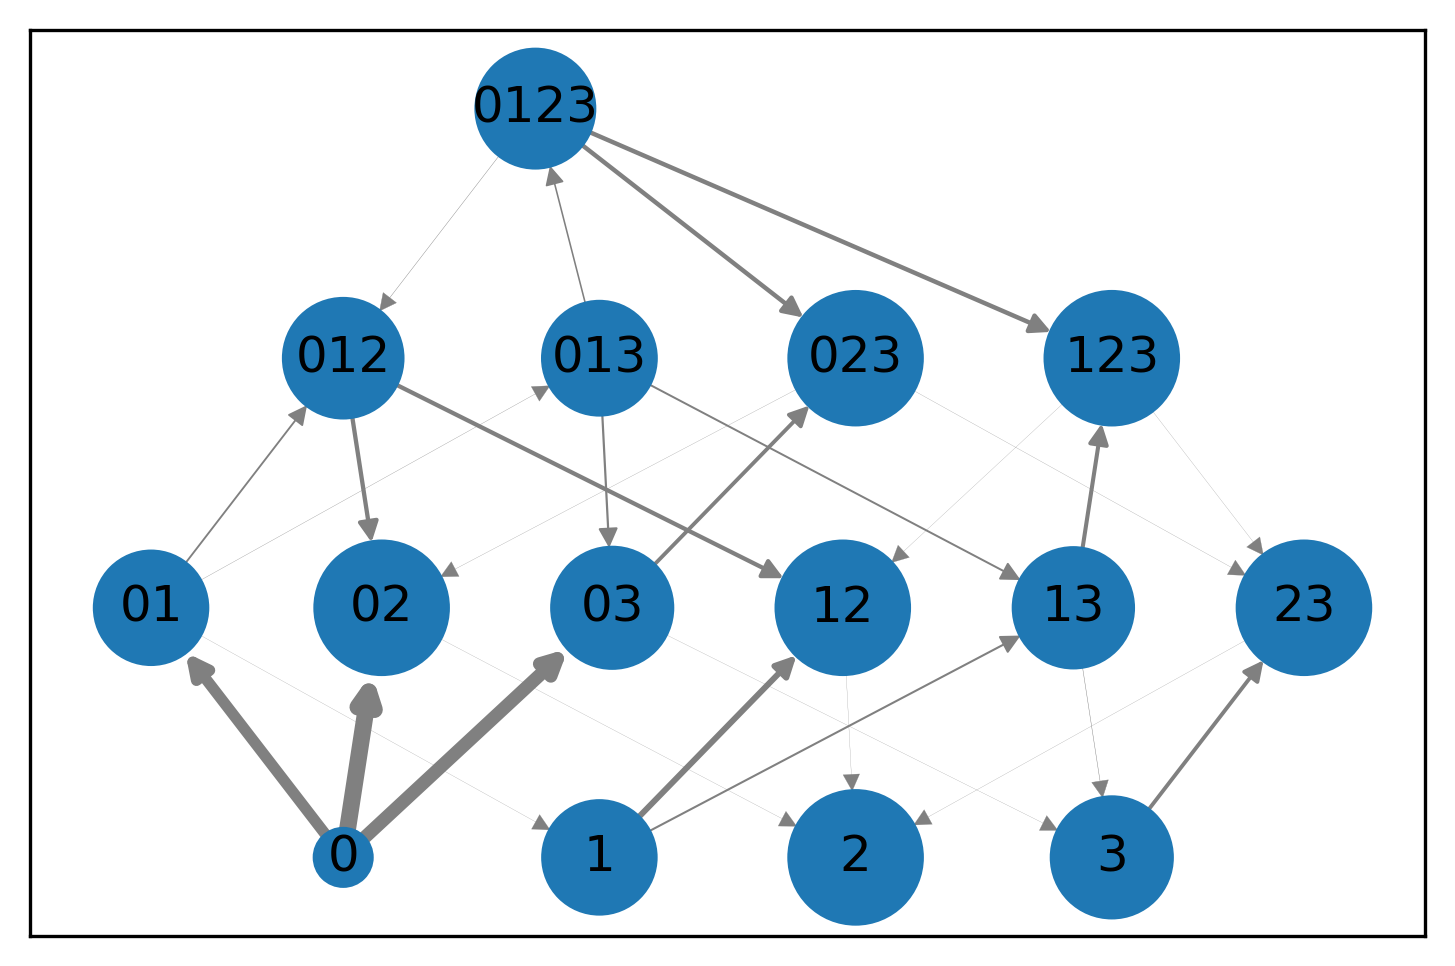

In [9]:
pyrsa.vis.show_family_graph(model_family,results,node_property="area")